# Data Visualisations Notebook

## Objectives

* Answer business requirement 1:
    *The client is interested to have a study to visually differentiate a powdery mildew leaf and healthy leaf.

## Inputs
* inputs/leaves_dataset/cherry-leaves/processed_images/train
* inputs/leaves_dataset/cherry-leaves/processed_images/test
* inputs/leaves_dataset/cherry-leaves/processed_images/validation

## Outputs
* Image shape embeddings pickle file.
* Mean and variability of images per label plot.
* Plot to distinguish the contrast between powdery mildew leaf and healthy leaf images.
* Generate code that answers business requirement 1 and can be used to build an image montage on the Streamlit dashboard.

## Additional Comments

* No Additional Comments

Set Working Directory

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-Cherry-Leaves/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-Cherry-Leaves'

Import Libraries

In [ ]:
import os
import shutil
import itertools
import random
import re
import joblib
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras._tf_keras.keras.preprocessing import image

2025-04-29 10:32:17.054410: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-29 10:32:17.055989: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-29 10:32:17.059127: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-29 10:32:17.072913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745922737.089872     627 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745922737.09

Setting Input Directories

In [5]:
my_data_dir = 'inputs/leaves_dataset/cherry-leaves/processed_images'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

Setting Output Directories 

Automatic Version Control moves all files and directories to the latest version folder, and
removes any now-empty previous version folders.

In [6]:
def get_version_folders(base_path):
    version_folders = []
    for folder in os.listdir(base_path):
        full_path = os.path.join(base_path, folder)
        if os.path.isdir(full_path) and re.match(r'^v\d+$', folder):
            version_folders.append((int(folder[1:]), folder))
    return sorted(version_folders)

def move_files_to_latest(base_path):
    version_folders = get_version_folders(base_path)
    if not version_folders:
        print("No version folders found.")
        return

    latest_version_num, latest_version = version_folders[-1]
    latest_path = os.path.join(base_path, latest_version)

    for version_num, version_name in version_folders[:-1]:
        version_path = os.path.join(base_path, version_name)
        for root, dirs, files in os.walk(version_path, topdown=False):
            for file in files:
                src_file = os.path.join(root, file)
                relative_path = os.path.relpath(src_file, version_path)
                dest_file = os.path.join(latest_path, relative_path)

                os.makedirs(os.path.dirname(dest_file), exist_ok=True)
                shutil.move(src_file, dest_file)

            for dir in dirs:
                dir_path = os.path.join(root, dir)
                if not os.listdir(dir_path):  # Remove empty subdirs
                    os.rmdir(dir_path)

        # After moving, remove version folder if empty
        if not os.listdir(version_path):
            os.rmdir(version_path)
            print(f"Removed empty folder: {version_name}")

    print(f"✅ All files moved to: {latest_version}")

if __name__ == "__main__":
    base_directory = '/workspaces/PP5-Cherry-Leaves/outputs'  # 🔧 Change this to your folder path
    move_files_to_latest(base_directory)

✅ All files moved to: v13


In [7]:
# Set the labels
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['powdery_mildew', 'healthy']


## Image Data Visualisations

check for average image size on train set

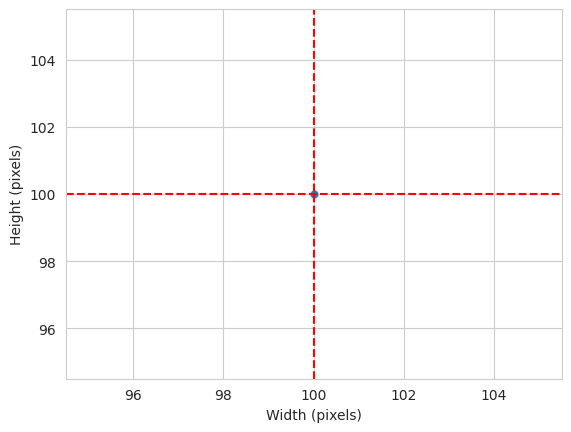

Width average: 100 
Height average: 100


In [8]:
# code sourced from walkthrough 1 - Malaria Detector Project

dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

Setting up image retrieval from '.pkl' file to define image shape.

In [10]:
with open('/workspaces/PP5-Cherry-Leaves/outputs/image_shape_1.pkl', 'rb') as f:
    data = pickle.load(f)

print(type(data))
print(data)

<class 'tuple'>
(100, 100, 3)


In [12]:
# Load the shape from the .pkl file
with open('/workspaces/PP5-Cherry-Leaves/outputs/image_shape_1.pkl', 'rb') as f:
    image_shape = pickle.load(f)

# Now image_shape == (100, 100, 3)
print("Loaded image shape:", image_shape)


Loaded image shape: (100, 100, 3)


saving image shape whilst incorporating an auto file numbering system to avoid overwriting files

In [13]:
# based on save image shape in Malaria detector - Walkthrough Project 
# Automation with the aid of official python docs
# Settings


file_path = '/workspaces/PP5-Cherry-Leaves/outputs'  # Your output directory
file_prefix = 'image_shape'
file_extension = '.pkl'

# Make sure the directory exists
os.makedirs(file_path, exist_ok=True)

# List all existing image_shape_*.pkl files
existing_files = [
    f for f in os.listdir(file_path)
    if f.startswith(file_prefix + '_') and f.endswith(file_extension)
]

# Extract numbers from filenames like image_shape_1.pkl
existing_numbers = [
    int(f[len(file_prefix) + 1:-len(file_extension)])
    for f in existing_files
    if f[len(file_prefix) + 1:-len(file_extension)].isdigit()
]

# Determine the next number to use
next_number = max(existing_numbers, default=0) + 1
new_filename = f"{file_prefix}_{next_number}{file_extension}"
full_save_path = os.path.join(file_path, new_filename)

# Example image shape to save
image_shape = (100, 100, 3)

# Save the file
with open(full_save_path, 'wb') as f:
    pickle.dump(image_shape, f)

print(f"✅ Image shape saved to: {full_save_path}")

✅ Image shape saved to: /workspaces/PP5-Cherry-Leaves/outputs/image_shape_2.pkl


---

Average and Variability of images per label

load images into a tensor array

In [14]:
def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            # n_images_per_label: we set a limit, since it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

print sample data array

In [15]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 100, 100, 3) (60,)


In [16]:
# Code used from Walkthrough 1 - Malaria Detector

def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    """
    The pseudo-code for the function is:
    * Loop over all labels
    * Subset an array for a given label
    * Calculate the mean and standard deviation
    * Create a figure displaying the mean and variability of images
    * Save the image
    """

    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

==== Label healthy ====
Image Shape: (100, 100, 3)
==== Label powdery_mildew ====
Image Shape: (100, 100, 3)


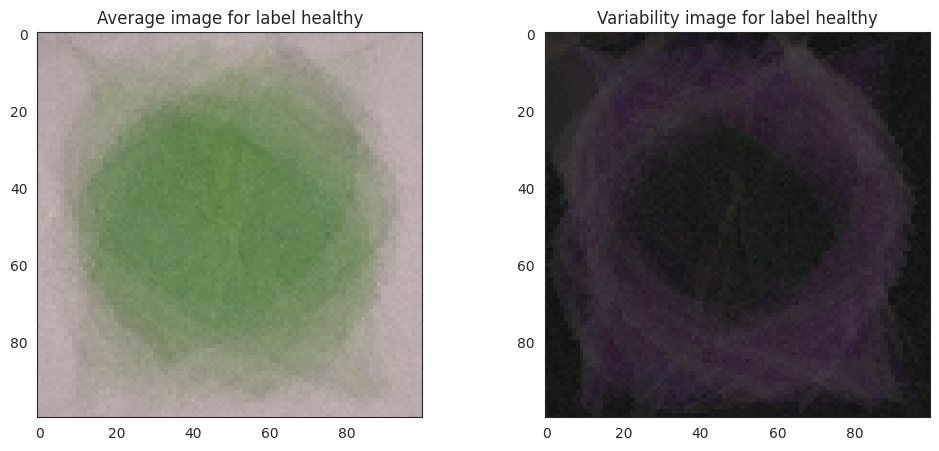

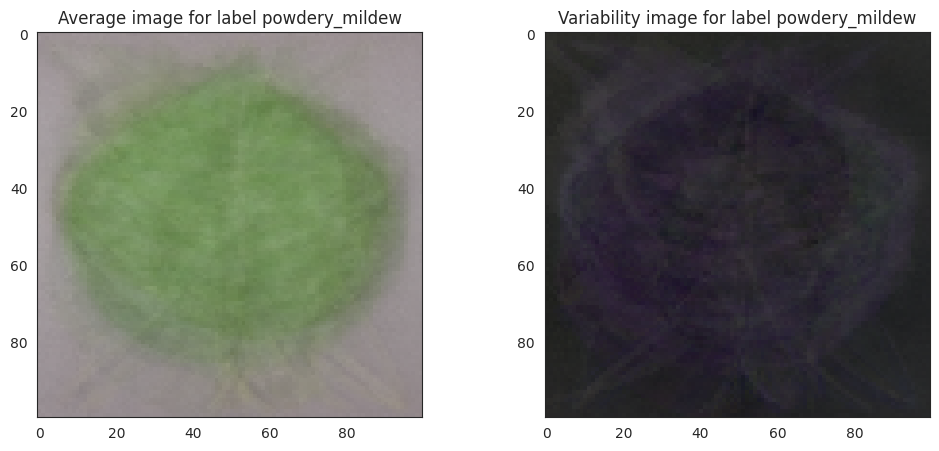

In [17]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True)

In [18]:
def subset_image_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    """
    Checks if the labels exist in the set of unique labels
    Calculates the mean and difference for label1 and label2
    Plots a chart and saves it if save_image=True
    """
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(
            f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
        return

    # calculate mean from label1
    images_label = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label, axis=0)

    # calculate mean from label2
    images_label = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label, axis=0)

    # calculate difference and plot difference, avg label1 and avg label2
    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


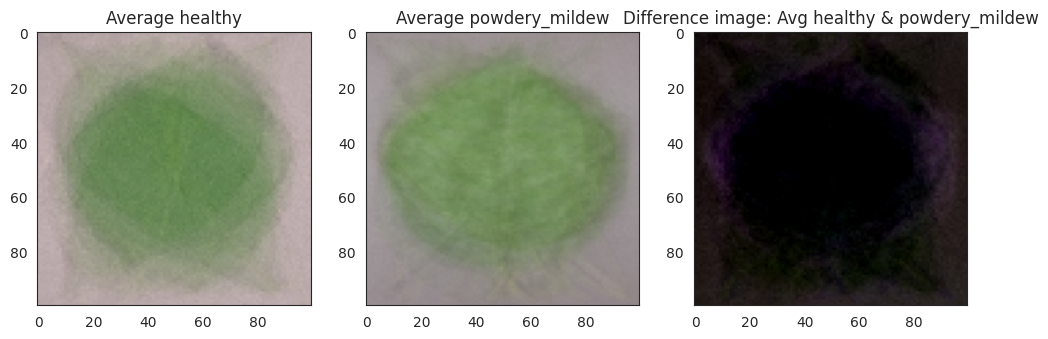

In [19]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='healthy', label_2='powdery_mildew',
                                        figsize=(12, 10),
                                        save_image=True
                                        )

---

# Image Montage

In [20]:
def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
    """
    if the label exists in the directory
    check if your montage space is greater than the subset size
    create a list of axes indices based on nrows and ncols
    create a Figure and display images
    in this loop, load and plot the given image
    """

    labels = os.listdir(dir_path)

    # subset the class you are interested to display
    if label_to_display in labels:

        # checks if your montage space is greater than the subset size
        images_list = os.listdir(dir_path + '/' + label_to_display)
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print(
                f"Decrease nrows or ncols to create your montage. \n"
                f"There are {len(images_list)} in your subset. "
                f"You requested a montage with {nrows * ncols} spaces")
            return

        # create a list of axes indices based on nrows and ncols
        list_rows = range(0, nrows)
        list_cols = range(0, ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        # create a Figure and display images
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0, nrows*ncols):
            img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
            img_shape = img.shape
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(
                f"Width {img_shape[1]}px x Height {img_shape[0]}px")
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        sns.set_style("white")
        plt.tight_layout()
        plt.show()

    else:
        print("The label you selected doesn't exist.")
        print(f"The existing options are: {labels}")

powdery_mildew


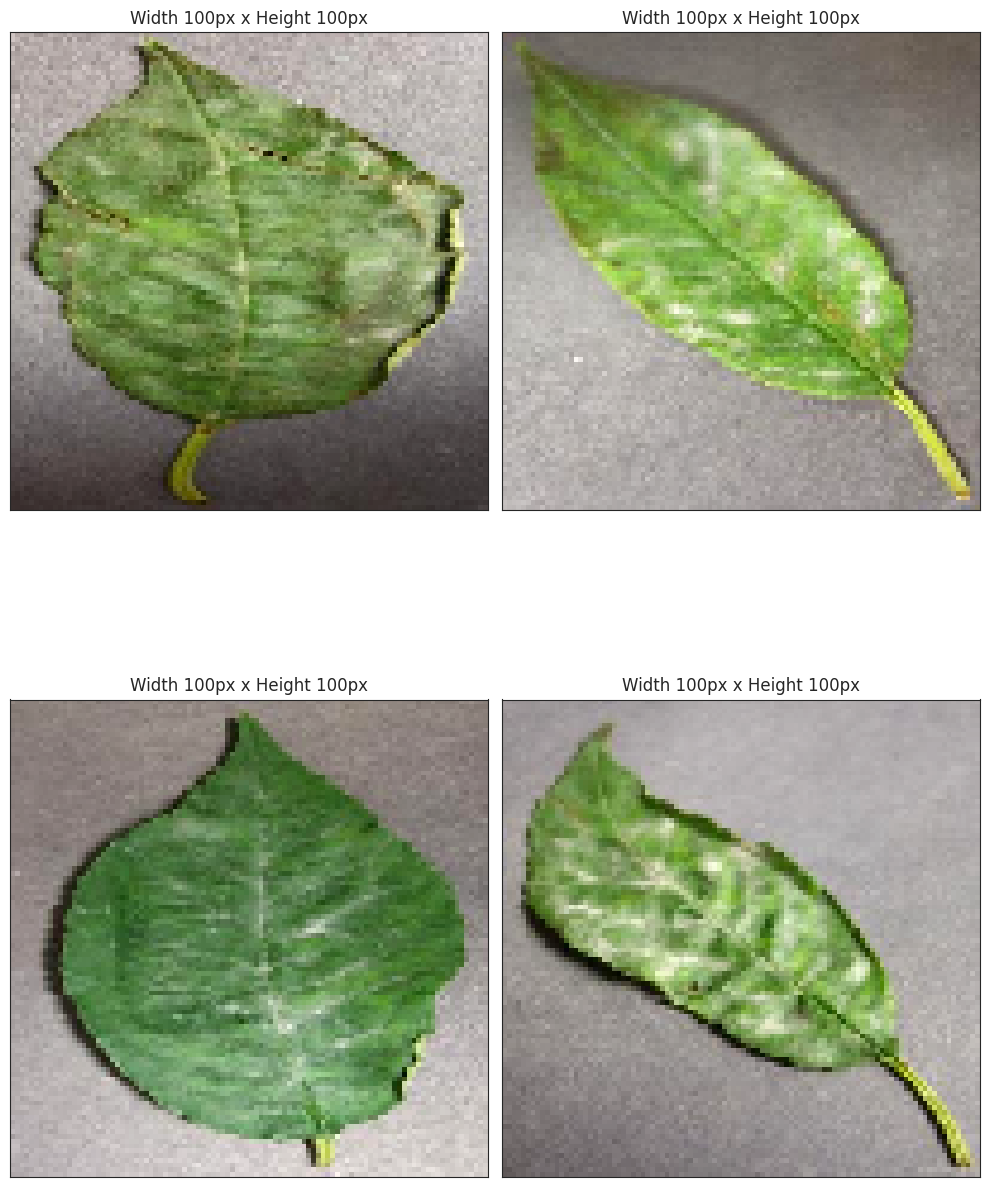



healthy


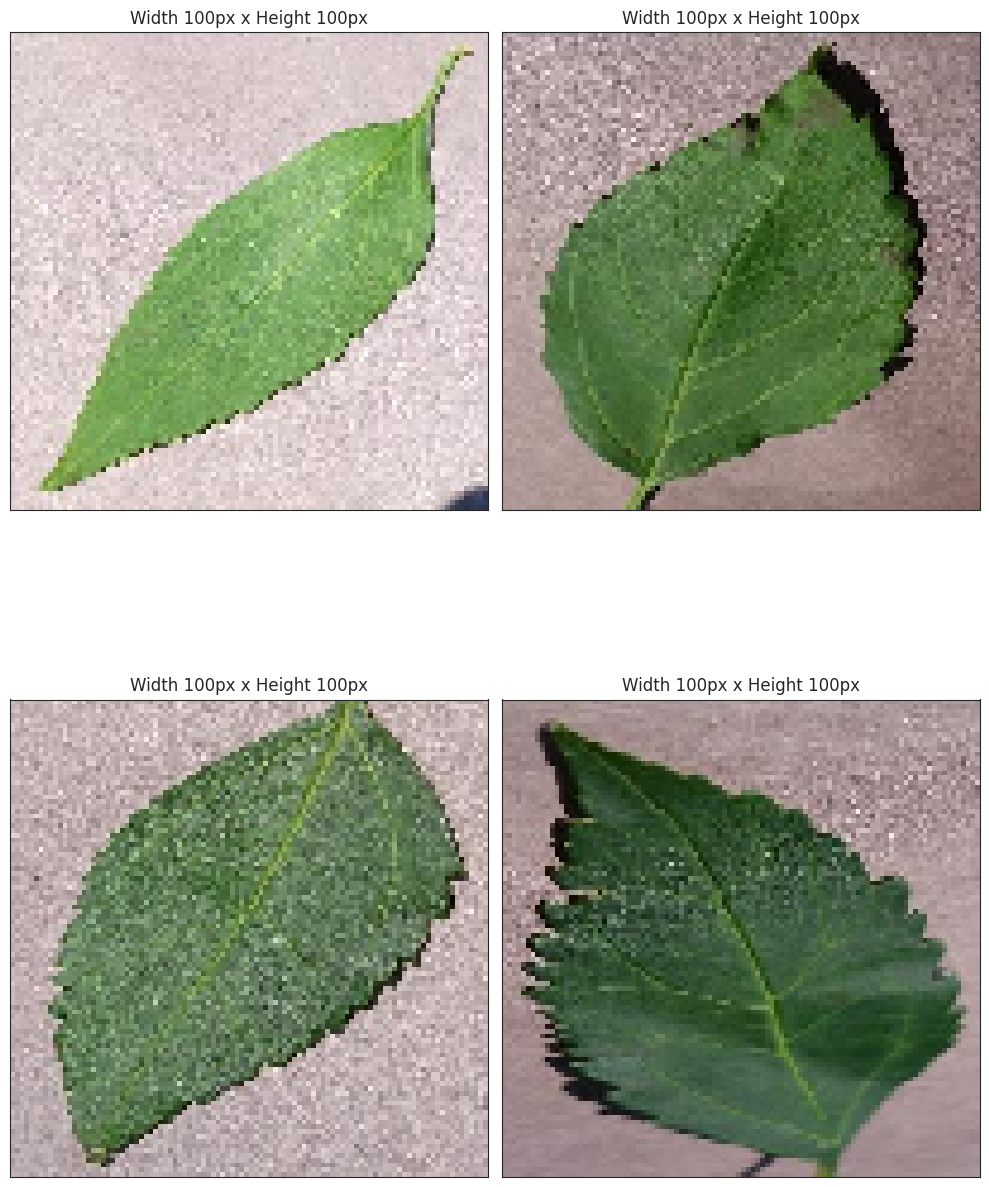

In [22]:
for label in labels:
    print(label)
    image_montage(dir_path=train_path,
                  label_to_display=label,
                  nrows=2, ncols=2,
                  figsize=(10, 15)
                  )
    print("\n")

---